In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import optuna
import logging

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

optuna.logging.set_verbosity(optuna.logging.WARNING)

In [32]:
df = pd.read_csv("../data/processed/processed_data.csv", parse_dates=["timestamp"])

In [33]:
df.head()

,timestamp,city,aqi,pollution_level,pollution_class,temp,humidity,rain,wind_speed,wind_dir,pressure,cloud,pm2_5,pm10,co,no2,o3,so2
0,2023-01-01,Biên Hòa,133,Unhealthy for Sensitive,2,23.0,64,0.0,10.3,12,1010.3,100,65.0,95.0,993.0,84.4,25.0,37.5
1,2023-01-01,Buôn Ma Thuột,53,Moderate,1,17.7,88,0.3,7.7,101,968.4,100,13.6,23.2,485.0,1.8,105.0,2.2
2,2023-01-01,Bắc Ninh,146,Unhealthy for Sensitive,2,11.1,75,0.0,6.2,353,1023.5,0,52.4,74.7,678.0,8.8,58.0,15.4
3,2023-01-01,Cao Bằng,82,Moderate,1,10.8,83,0.0,4.6,162,996.6,100,31.9,45.5,528.0,6.4,45.0,7.6
4,2023-01-01,Cao Lãnh,86,Moderate,1,24.4,55,0.0,12.0,7,1013.9,100,21.8,32.2,693.0,23.0,47.0,3.3


In [34]:
cols_to_drop = ["aqi", "pollution_level", "pollution_class"]
df = df.drop(columns=cols_to_drop, errors="ignore")
# Sort and handle duplicates/resampling
df = df.sort_values(by=["city", "timestamp"])
# Handle duplicates by taking the mean
df = df.groupby(["city", "timestamp"], observed=True).mean(numeric_only=True).reset_index()

In [35]:
df_feat = df.copy()

In [36]:
# Temporal & Social Context
# ==========================================
print("Processing Group 1: Temporal & Social...")

df_feat = df.copy()

# 1.1 Cyclical Hour
df_feat["hour"] = df_feat["timestamp"].dt.hour
df_feat["hour_sin"] = np.sin(2 * np.pi * df_feat["hour"] / 24)
df_feat["hour_cos"] = np.cos(2 * np.pi * df_feat["hour"] / 24)

# 1.2 Day Parts
def get_day_part(h):
    if 5 <= h < 10: return "morning"
    elif 10 <= h < 15: return "midday"
    elif 15 <= h < 18: return "afternoon"
    elif 18 <= h < 23: return "evening"
    else: return "night"

df_feat["day_part"] = df_feat["hour"].apply(get_day_part).astype("category")

# 1.3 Rush Hour
df_feat["is_rush_hour"] = df_feat["hour"].isin([7, 8, 9, 17, 18, 19]).astype(int)

# 1.4 Weekend
df_feat["dayofweek"] = df_feat["timestamp"].dt.dayofweek
df_feat["is_weekend"] = (df_feat["dayofweek"] >= 5).astype(int)

# 1.5 Season
df_feat["month"] = df_feat["timestamp"].dt.month
def month_to_season(m):
    if m in [12, 1, 2]: return "winter"
    elif m in [3, 4, 5]: return "spring"
    elif m in [6, 7, 8]: return "summer"
    else: return "autumn"

df_feat["season"] = df_feat["month"].apply(month_to_season).astype("category")

# Cyclical Month
df_feat["month_sin"] = np.sin(2 * np.pi * df_feat["month"] / 12)
df_feat["month_cos"] = np.cos(2 * np.pi * df_feat["month"] / 12)

# Convert City to Category
df_feat["city"] = df_feat["city"].astype("category")

Processing Group 1: Temporal & Social...


In [37]:
# Physics & Meteorology
# ==========================================
print("Processing Group 2: Physics & Meteo...")

# 2.1 Wind Vector
if "wind_speed" in df_feat.columns and "wind_dir" in df_feat.columns:
    wd_rad = df_feat["wind_dir"] * np.pi / 180
    df_feat["wind_x"] = df_feat["wind_speed"] * np.cos(wd_rad)
    df_feat["wind_y"] = df_feat["wind_speed"] * np.sin(wd_rad)
    df_feat = df_feat.drop(columns=["wind_dir"], errors="ignore")

# 2.2 Cumulative Rain (Washout effect)
if "rain" in df_feat.columns:
    df_feat["rain_sum_6h"] = df_feat.groupby("city", observed=True)["rain"].shift(1).rolling(6).sum().reset_index(0, drop=True)

# 2.3 Temperature Difference 24h (Inversion proxy)
if "temp" in df_feat.columns:
    temp_shifted = df_feat.groupby("city", observed=True)["temp"].shift(1)
    df_feat["temp_diff_24h"] = (
        temp_shifted.rolling(24).max() - temp_shifted.rolling(24).min()
    ).reset_index(0, drop=True)

# 2.4 Humidity-Temperature Interaction
if "humidity" in df_feat.columns and "temp" in df_feat.columns:
    df_feat["humid_x_temp"] = df_feat["humidity"] * df_feat["temp"]

Processing Group 2: Physics & Meteo...


In [38]:
# History & Trend
# ==========================================
print("Processing Group 3: History & Trend...")
target = "pm2_5"

# 3.1 Lag Features
lags = [1, 2, 3, 24]
for lag in lags:
    df_feat[f"pm25_lag_{lag}h"] = df_feat.groupby("city", observed=True)[target].shift(lag)

# 3.2 Rolling Statistics
pm25_shifted = df_feat.groupby("city", observed=True)[target].shift(1)

# Short-term (6h)
df_feat["pm25_rm_6h"] = pm25_shifted.rolling(6).mean().reset_index(0, drop=True)
df_feat["pm25_rs_6h"] = pm25_shifted.rolling(6).std().reset_index(0, drop=True)

# Long-term (24h)
df_feat["pm25_rm_24h"] = pm25_shifted.rolling(24).mean().reset_index(0, drop=True)

# 3.3 Short-term Trend
df_feat["pm25_trend_1h"] = df_feat["pm25_lag_1h"] - df_feat["pm25_lag_2h"]

Processing Group 3: History & Trend...


In [39]:
# Composition
# ==========================================
print("Processing Group 4: Composition...")

if "pm10" in df_feat.columns and "pm2_5" in df_feat.columns:
    # Coarse Dust
    df_feat["coarse_dust"] = df_feat["pm10"] - df_feat["pm2_5"]
    # PM Ratio
    df_feat["pm_ratio"] = df_feat["pm2_5"] / (df_feat["pm10"] + 1e-6)

# Exogenous Lags
exo_cols = ["no2", "so2", "co", "o3", "coarse_dust", "pm_ratio", "pm10"]
for col in exo_cols:
    if col in df_feat.columns:
        df_feat[f"{col}_lag1h"] = df_feat.groupby("city", observed=True)[col].shift(1)

Processing Group 4: Composition...


## Linear 

In [59]:
df_model = df_feat.copy()

# Create Target (Shift -1 hour)
df_model["target_future"] = df_model.groupby("city", observed=True)["pm2_5"].shift(-1)

# Drop NaNs created by lags/rolling/shift
df_model = df_model.dropna()

# Define dates for split
val_start_date = pd.Timestamp("2025-08-01")
test_start_date = pd.Timestamp("2025-10-01")

# Split Data
train = df_model[df_model["timestamp"] < val_start_date]
val = df_model[(df_model["timestamp"] >= val_start_date) & (df_model["timestamp"] < test_start_date)]
test = df_model[df_model["timestamp"] >= test_start_date]

# Separate Features and Target
X_train = train.drop(columns=["timestamp", "target_future"])
y_train = train["target_future"]

X_val = val.drop(columns=["timestamp", "target_future"])
y_val = val["target_future"]

X_test = test.drop(columns=["timestamp", "target_future"])
y_test = test["target_future"]

# Save meta for plotting
test_meta = test[["city", "timestamp", "target_future"]]

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)} | Test Size: {len(X_test)}")

Train Size: 768672 | Val Size: 49776 | Test Size: 45696


In [60]:
df_model.columns

Index(['city', 'timestamp', 'temp', 'humidity', 'rain', 'wind_speed',
       'pressure', 'cloud', 'pm2_5', 'pm10', 'co', 'no2', 'o3', 'so2', 'hour',
       'hour_sin', 'hour_cos', 'day_part', 'is_rush_hour', 'dayofweek',
       'is_weekend', 'month', 'season', 'month_sin', 'month_cos', 'wind_x',
       'wind_y', 'rain_sum_6h', 'temp_diff_24h', 'humid_x_temp', 'pm25_lag_1h',
       'pm25_lag_2h', 'pm25_lag_3h', 'pm25_lag_24h', 'pm25_rm_6h',
       'pm25_rs_6h', 'pm25_rm_24h', 'pm25_trend_1h', 'coarse_dust', 'pm_ratio',
       'no2_lag1h', 'so2_lag1h', 'co_lag1h', 'o3_lag1h', 'coarse_dust_lag1h',
       'pm_ratio_lag1h', 'pm10_lag1h', 'target_future'],
      dtype='object')

In [61]:
cat_cols = [
    c for c in X_train.columns
    if X_train[c].dtype == "category" or X_train[c].nunique() < 20
]

num_cols = [c for c in X_train.columns if c not in cat_cols]

In [62]:
linear_pipeline1 = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("linreg", LinearRegression(n_jobs=-1))
])



linear_pipeline1.fit(X_train, y_train)


# Validation
val_pred_lin = linear_pipeline1.predict(X_val)
val_rmse_lin = np.sqrt(mean_squared_error(y_val, val_pred_lin))
val_mae_lin  = mean_absolute_error(y_val, val_pred_lin)

# Test
test_pred_lin = linear_pipeline1.predict(X_test)
test_rmse_lin = np.sqrt(mean_squared_error(y_test, test_pred_lin))
test_mae_lin  = mean_absolute_error(y_test, test_pred_lin)

print(f"[Linear] VAL  RMSE={val_rmse_lin:.4f} MAE={val_mae_lin:.4f}")
print(f"[Linear] TEST RMSE={test_rmse_lin:.4f} MAE={test_mae_lin:.4f}")

[Linear] VAL  RMSE=4.0095 MAE=1.9835
[Linear] TEST RMSE=3.3719 MAE=1.7804


In [63]:
lin_model = linear_pipeline1.named_steps["linreg"]
preprocess = linear_pipeline1.named_steps["preprocess"]

# Numeric features (giữ nguyên tên)
num_features = num_cols

# Categorical features sau one-hot
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(cat_cols)

# Ghép toàn bộ feature names
feature_names = np.concatenate([num_features, cat_features])

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df.head(20)


,Feature,Coefficient,Abs_Coefficient
6,pm2_5,17.081103,17.081103
7,pm10,12.241782,12.241782
28,coarse_dust,-4.629190,4.629190
20,pm25_lag_1h,-2.920703,2.920703
21,pm25_lag_2h,-2.810490,2.810490
9,no2,2.603177,2.603177
30,no2_lag1h,-2.280738,2.280738
24,pm25_rm_6h,-2.188382,2.188382
67,city_Đà Lạt,-2.017300,2.017300
36,pm10_lag1h,-1.934188,1.934188


Evaluating Linear Regression Model...


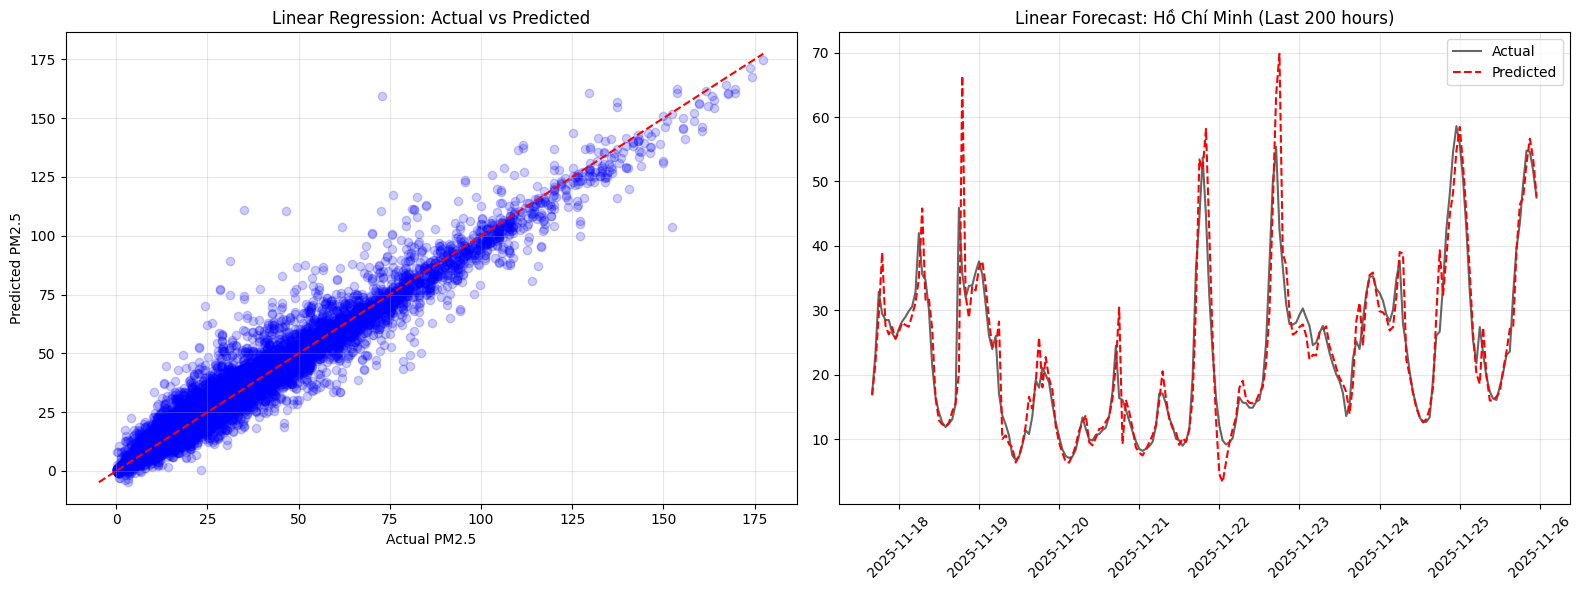

In [64]:
print("Evaluating Linear Regression Model...")

preds = test_pred_lin

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ======================================================
# Plot A: Scatter Plot (Actual vs Predicted)
# ======================================================
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("Linear Regression: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# ======================================================
# Plot B: Forecast for a Sample City
# ======================================================
sample_city = "Hồ Chí Minh"

mask = test_meta["city"] == sample_city
if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 200
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"Linear Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()


## Linear Base with drop pm10

In [68]:
print("Preparing Data for Training...")

df_model2 = df_feat.copy()
col_drop = ["pm10", "coarse_dust", "pm_ratio", "pm10_lag1h", "coarse_dust_lag1h", "pm_ratio_lag1h"]
df_model2 = df_model2.drop(columns=col_drop, errors="ignore")

# Create Target (Shift -1 hour)
df_model2["target_future"] = df_model2.groupby("city", observed=True)["pm2_5"].shift(-1)

# Drop NaNs created by lags/rolling/shift
df_model2 = df_model2.dropna()

# Define dates for split
val_start_date = pd.Timestamp("2025-08-01")
test_start_date = pd.Timestamp("2025-10-01")

# Split Data
train2 = df_model2[df_model2["timestamp"] < val_start_date]
val2 = df_model2[(df_model2["timestamp"] >= val_start_date) & (df_model2["timestamp"] < test_start_date)]
test2 = df_model2[df_model2["timestamp"] >= test_start_date]

# Separate Features and Target
X_train2 = train2.drop(columns=["timestamp", "target_future"])
y_train2 = train2["target_future"]

X_val2 = val2.drop(columns=["timestamp", "target_future"])
y_val2 = val2["target_future"]

X_test2 = test2.drop(columns=["timestamp", "target_future"])
y_test2 = test2["target_future"]

# Save meta for plotting
test_meta = test2[["city", "timestamp", "target_future"]]
print(f"Train Size: {len(X_train2)} | Val Size: {len(X_val2)} | Test Size: {len(X_test2)}")

Preparing Data for Training...
Train Size: 768672 | Val Size: 49776 | Test Size: 45696


In [69]:
print(X_train2.columns)

Index(['city', 'temp', 'humidity', 'rain', 'wind_speed', 'pressure', 'cloud',
       'pm2_5', 'co', 'no2', 'o3', 'so2', 'hour', 'hour_sin', 'hour_cos',
       'day_part', 'is_rush_hour', 'dayofweek', 'is_weekend', 'month',
       'season', 'month_sin', 'month_cos', 'wind_x', 'wind_y', 'rain_sum_6h',
       'temp_diff_24h', 'humid_x_temp', 'pm25_lag_1h', 'pm25_lag_2h',
       'pm25_lag_3h', 'pm25_lag_24h', 'pm25_rm_6h', 'pm25_rs_6h',
       'pm25_rm_24h', 'pm25_trend_1h', 'no2_lag1h', 'so2_lag1h', 'co_lag1h',
       'o3_lag1h'],
      dtype='object')


In [70]:
df_model2.columns

Index(['city', 'timestamp', 'temp', 'humidity', 'rain', 'wind_speed',
       'pressure', 'cloud', 'pm2_5', 'co', 'no2', 'o3', 'so2', 'hour',
       'hour_sin', 'hour_cos', 'day_part', 'is_rush_hour', 'dayofweek',
       'is_weekend', 'month', 'season', 'month_sin', 'month_cos', 'wind_x',
       'wind_y', 'rain_sum_6h', 'temp_diff_24h', 'humid_x_temp', 'pm25_lag_1h',
       'pm25_lag_2h', 'pm25_lag_3h', 'pm25_lag_24h', 'pm25_rm_6h',
       'pm25_rs_6h', 'pm25_rm_24h', 'pm25_trend_1h', 'no2_lag1h', 'so2_lag1h',
       'co_lag1h', 'o3_lag1h', 'target_future'],
      dtype='object')

In [71]:
cat_cols = [
    c for c in X_train2.columns
    if X_train2[c].dtype == "category" or X_train2[c].nunique() < 20
]

num_cols = [c for c in X_train2.columns if c not in cat_cols]

In [72]:
linear_pipeline2 = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("linreg", LinearRegression(n_jobs=-1))
])



linear_pipeline2.fit(X_train2, y_train2)


# Validation
val_pred_lin = linear_pipeline2.predict(X_val2)
val_rmse_lin = np.sqrt(mean_squared_error(y_val2, val_pred_lin))
val_mae_lin  = mean_absolute_error(y_val2, val_pred_lin)

# Test
test_pred_lin = linear_pipeline2.predict(X_test2)
test_rmse_lin = np.sqrt(mean_squared_error(y_test2, test_pred_lin))
test_mae_lin  = mean_absolute_error(y_test2, test_pred_lin)

print(f"[Linear] VAL  RMSE={val_rmse_lin:.4f} MAE={val_mae_lin:.4f}")
print(f"[Linear] TEST RMSE={test_rmse_lin:.4f} MAE={test_mae_lin:.4f}")

[Linear] VAL  RMSE=4.0034 MAE=1.9834
[Linear] TEST RMSE=3.3619 MAE=1.7799


In [51]:
lin_model = linear_pipeline2.named_steps["linreg"]
preprocess = linear_pipeline2.named_steps["preprocess"]

# Numeric features (giữ nguyên tên)
num_features = num_cols

# Categorical features sau one-hot
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(cat_cols)

# Ghép toàn bộ feature names
feature_names = np.concatenate([num_features, cat_features])

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df.head(20)

,Feature,Coefficient,Abs_Coefficient
6,pm2_5,26.489020,26.489020
19,pm25_lag_1h,-3.527020,3.527020
20,pm25_lag_2h,-3.392109,3.392109
8,no2,2.679115,2.679115
27,no2_lag1h,-2.331763,2.331763
61,city_Đà Lạt,-2.237934,2.237934
23,pm25_rm_6h,-2.198579,2.198579
25,pm25_rm_24h,1.940666,1.940666
44,city_Lai Châu,-1.874631,1.874631
60,city_Điện Biên Phủ,-1.618739,1.618739


Evaluating Linear Regression Model...


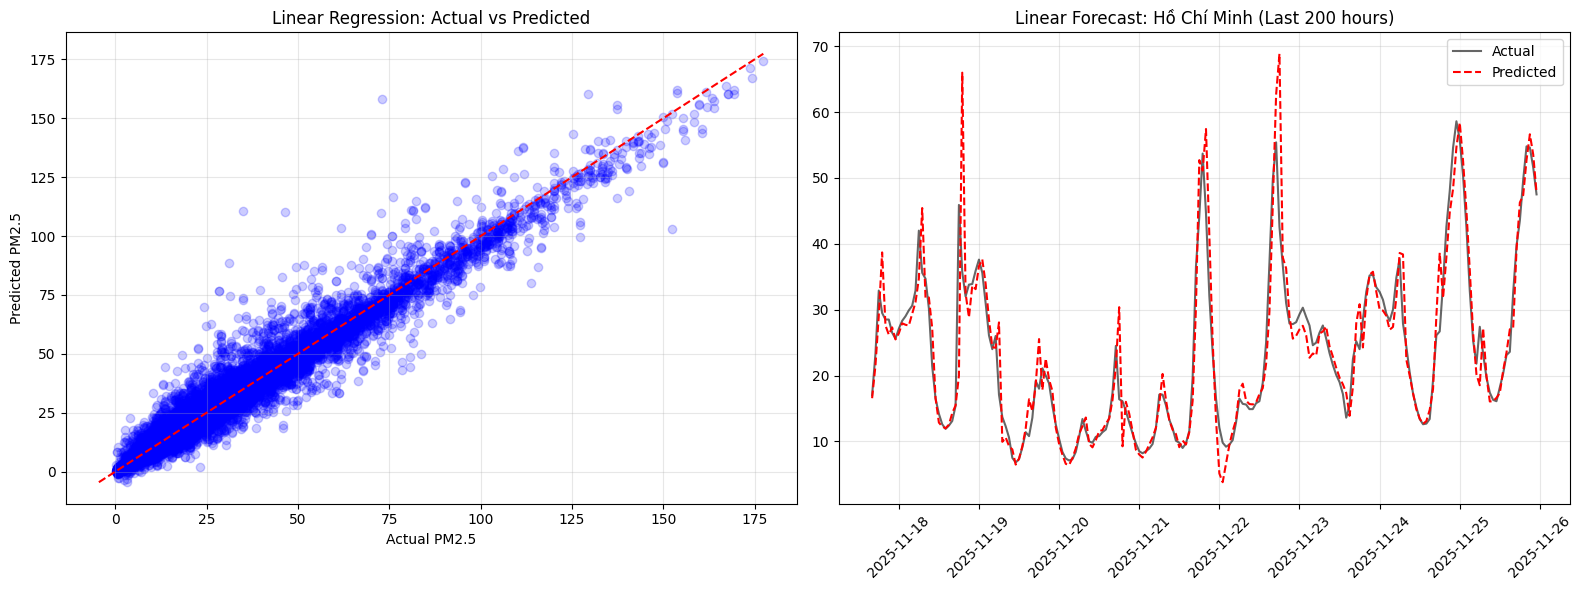

In [73]:
print("Evaluating Linear Regression Model...")

preds = test_pred_lin

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ======================================================
# Plot A: Scatter Plot (Actual vs Predicted)
# ======================================================
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("Linear Regression: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# ======================================================
# Plot B: Forecast for a Sample City
# ======================================================
sample_city = "Hồ Chí Minh"

mask = test_meta["city"] == sample_city
if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 200
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"Linear Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()


## PCR


In [53]:
# results_pcr = []

# for k in range(50, 100, 5):  # 50, 55, 60, ..., 95 components
#     pcr_pipeline = Pipeline([
#         ("preprocess", ColumnTransformer(
#             transformers=[
#                 ("num", StandardScaler(), num_cols),
#                 ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
#             ]
#         )),
#         ("pca", PCA(n_components=k, random_state=42)),
#         ("linreg", LinearRegression(n_jobs=-1))
#     ])
    
#     pcr_pipeline.fit(X_train, y_train)
#     val_pred = pcr_pipeline.predict(X_val)
#     val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
#     results_pcr.append((k, val_rmse))

# pcr_results_df = pd.DataFrame(results_pcr, columns=["n_components", "Val_RMSE"])
# pcr_results_df

In [54]:
print("Training PCR Model...")

pcr_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("pca", PCA(n_components=90, random_state=42)),
    ("linreg", LinearRegression(n_jobs=-1))
])

pcr_pipeline.fit(X_train, y_train)

# Validation
val_pred_pcr = pcr_pipeline.predict(X_val)
val_rmse_pcr = np.sqrt(mean_squared_error(y_val, val_pred_pcr))
val_mae_pcr  = mean_absolute_error(y_val, val_pred_pcr)

# Test
test_pred_pcr = pcr_pipeline.predict(X_test)
test_rmse_pcr = np.sqrt(mean_squared_error(y_test, test_pred_pcr))
test_mae_pcr  = mean_absolute_error(y_test, test_pred_pcr)

print(f"[PCR] VAL  RMSE={val_rmse_pcr:.4f} MAE={val_mae_pcr:.4f}")
print(f"[PCR] TEST RMSE={test_rmse_pcr:.4f} MAE={test_mae_pcr:.4f}")

Training PCR Model...
[PCR] VAL  RMSE=4.0034 MAE=1.9834
[PCR] TEST RMSE=3.3619 MAE=1.7799


Evaluating PCR Model...


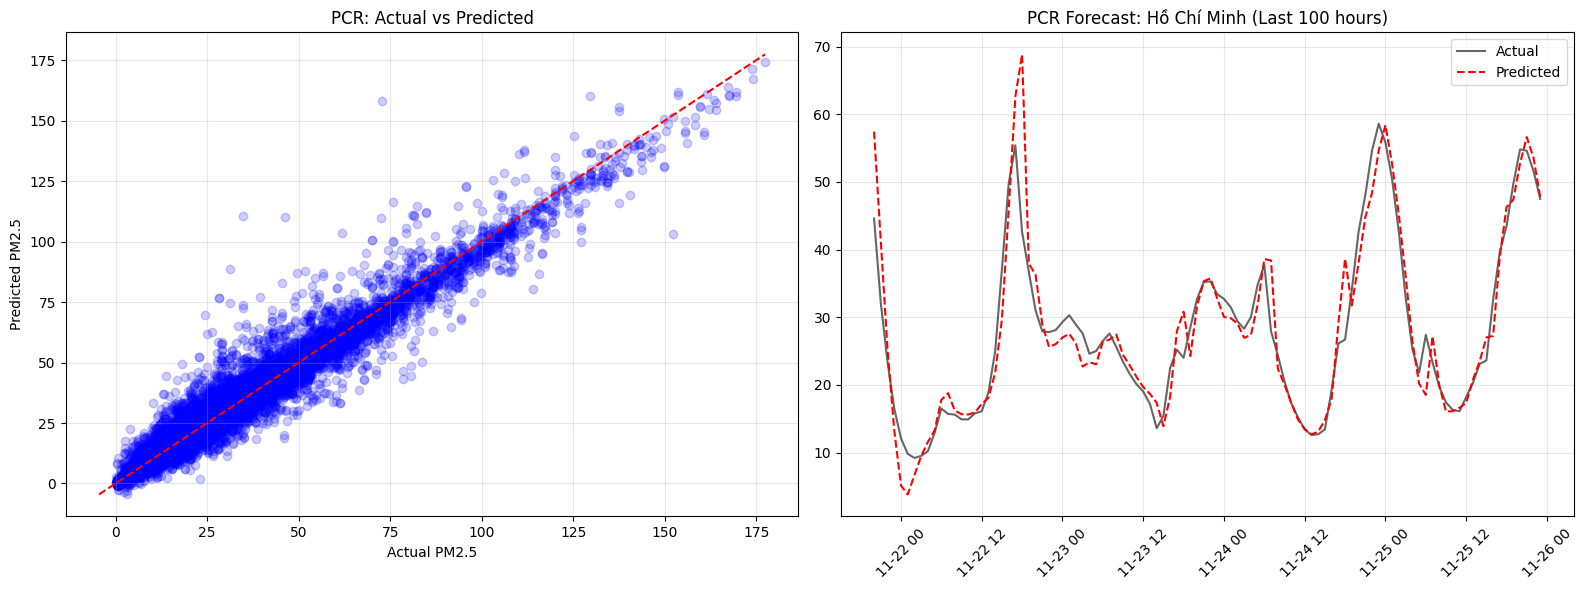

In [55]:
print("Evaluating PCR Model...")

preds = test_pred_pcr

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Actual vs Predicted
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("PCR: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Forecast theo thành phố
sample_city = "Hồ Chí Minh"
mask = test_meta["city"] == sample_city

if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 100
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"PCR Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()


## PLS

In [56]:
# print("Tuning PLS n_components...")

# results_pls = []

# for k in range(1, 10):  # thử từ 15 → 24 components
#     pls_pipeline = Pipeline([
#         ("preprocess", ColumnTransformer(
#             transformers=[
#                 ("num", StandardScaler(), num_cols),
#                 ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
#             ]
#         )),
#         ("pls", PLSRegression(n_components=k))
#     ])
    
#     pls_pipeline.fit(X_train, y_train)
#     val_pred = pls_pipeline.predict(X_val).ravel()
#     val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    
#     results_pls.append((k, val_rmse))

# pls_results_df = pd.DataFrame(results_pls, columns=["n_components", "Val_RMSE"])
# pls_results_df

In [57]:
print("Training PLS Model...")


pls_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("pls", PLSRegression(n_components=22))
])

pls_pipeline.fit(X_train, y_train)

# Validation
val_pred_pls = pls_pipeline.predict(X_val).ravel()
val_rmse_pls = np.sqrt(mean_squared_error(y_val, val_pred_pls))
val_mae_pls  = mean_absolute_error(y_val, val_pred_pls)

# Test
test_pred_pls = pls_pipeline.predict(X_test).ravel()
test_rmse_pls = np.sqrt(mean_squared_error(y_test, test_pred_pls))
test_mae_pls  = mean_absolute_error(y_test, test_pred_pls)

print(f"[PLS] VAL  RMSE={val_rmse_pls:.4f} MAE={val_mae_pls:.4f}")
print(f"[PLS] TEST RMSE={test_rmse_pls:.4f} MAE={test_mae_pls:.4f}")


Training PLS Model...
[PLS] VAL  RMSE=4.0345 MAE=2.0359
[PLS] TEST RMSE=3.4055 MAE=1.8396


Evaluating PLS Model...


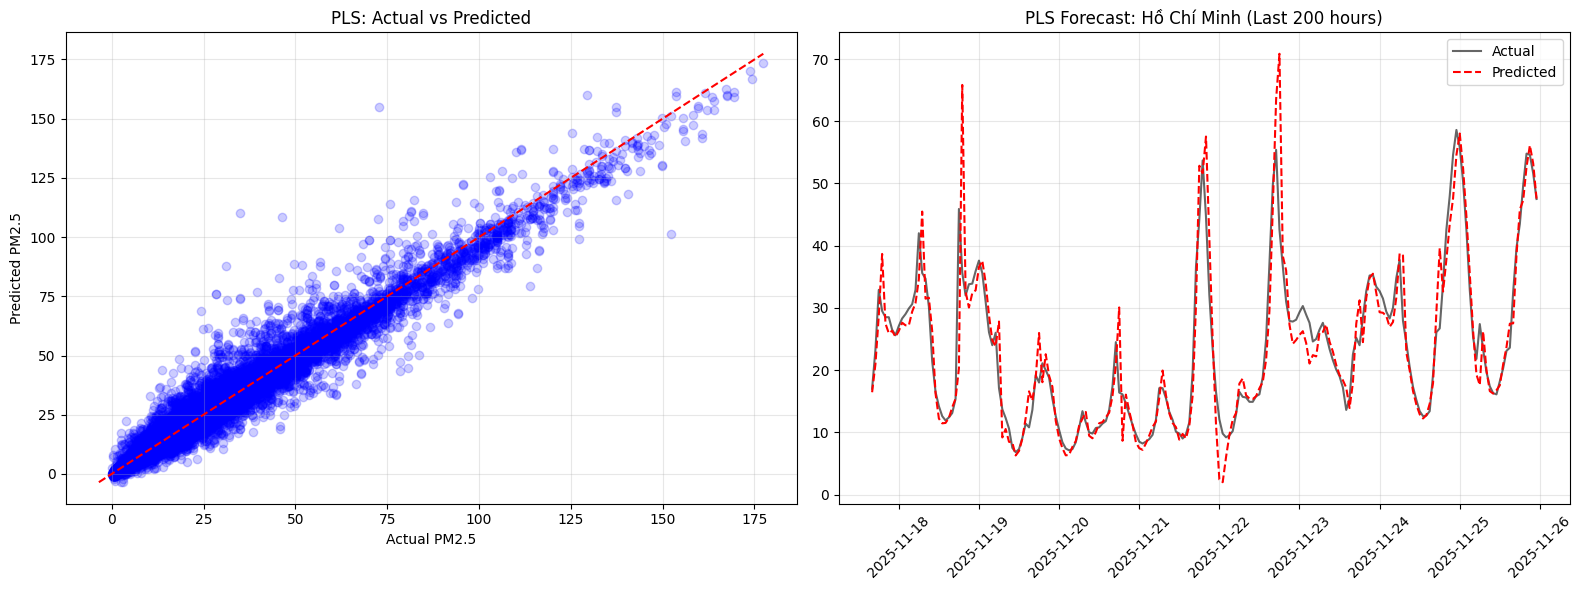

In [58]:
print("Evaluating PLS Model...")

preds = test_pred_pls

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter: Actual vs Predicted
axes[0].scatter(y_test, preds, alpha=0.2, color="blue")
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--")
axes[0].set_xlabel("Actual PM2.5")
axes[0].set_ylabel("Predicted PM2.5")
axes[0].set_title("PLS: Actual vs Predicted")
axes[0].grid(True, alpha=0.3)

# Forecast theo thành phố
sample_city = "Hồ Chí Minh"
mask = test_meta["city"] == sample_city

if mask.sum() > 0:
    city_dates = test_meta.loc[mask, "timestamp"]
    city_actual = y_test[mask]
    city_preds = preds[mask]

    tail = 200
    axes[1].plot(city_dates[-tail:], city_actual[-tail:], label="Actual", color="black", alpha=0.6)
    axes[1].plot(city_dates[-tail:], city_preds[-tail:], label="Predicted", color="red", linestyle="--")
    axes[1].set_title(f"PLS Forecast: {sample_city} (Last {tail} hours)")
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=45)
else:
    axes[1].text(0.5, 0.5, f"City {sample_city} not found", ha="center")

plt.tight_layout()
plt.show()
